In [8]:
import numpy as np
import matplotlib.pyplot as plt
from dataset_q1 import CustomTimeSeriesDataset, weighted_sampler_dataloader
from torch.utils.data import DataLoader
import torch
from sklearn.decomposition import PCA
import umap

from model_transfer_supervised import get_feature_extractor
from kl import KLdivergence

In [2]:
encoder_q1 = get_feature_extractor()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder_q1.to(device)

ResCNN(
  (conv1): Conv1d(1, 24, kernel_size=(5,), stride=(3,), padding=(1,))
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ELU(alpha=1.0)
  )
  (resblock2): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ELU(alpha=1.0)
  )
  (resblock3): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3

In [3]:
nettype = 'CNN'
# Load MIT-BIH
mitbih_train_dataset = CustomTimeSeriesDataset('mitbih_train.csv', NetType=nettype)
mitbih_train_loader = DataLoader(mitbih_train_dataset, batch_size=len(mitbih_train_dataset), shuffle=False)
mitbih_test_dataset = CustomTimeSeriesDataset('mitbih_test.csv', NetType=nettype)
mitbih_test_loader = DataLoader(mitbih_test_dataset, batch_size=len(mitbih_test_dataset), shuffle=False)

# Load PTB
ptb_train_dataset = CustomTimeSeriesDataset('ptbdb_train.csv', NetType=nettype)
ptb_train_loader = DataLoader(ptb_train_dataset, batch_size=len(ptb_train_dataset), shuffle=False)
ptb_test_dataset = CustomTimeSeriesDataset('ptbdb_test.csv', NetType=nettype)
ptb_test_loader = DataLoader(ptb_test_dataset, batch_size=len(ptb_test_dataset), shuffle=False)

print('mitbih_train: ', len(mitbih_train_dataset))
print('mitbih_test: ', len(mitbih_test_dataset))
print('ptb_train: ', len(ptb_train_dataset))
print('ptb_test: ', len(ptb_test_dataset))

mitbih_train:  87553
mitbih_test:  21891
ptb_train:  11640
ptb_test:  2910


In [4]:
mitbih_features = []
mitbih_labels = []

encoder_q1.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(mitbih_train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        mitbih_features.append(features.numpy())
        mitbih_labels.append(labels)
    for i, (inputs, labels) in enumerate(mitbih_test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        mitbih_features.append(features.numpy())
        mitbih_labels.append(labels)
        
# Concatenate features and labels lists
mitbih_features = np.concatenate(mitbih_features, axis=0)
mitbih_labels = np.concatenate(mitbih_labels, axis=0)

ptbdb_features = []
ptbdb_labels = []

encoder_q1.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(ptb_train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        ptbdb_features.append(features.numpy())
        ptbdb_labels.append(labels)
    for i, (inputs, labels) in enumerate(ptb_test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        ptbdb_features.append(features.numpy())
        ptbdb_labels.append(labels)
        
# Concatenate features and labels lists
ptbdb_features = np.concatenate(ptbdb_features, axis=0)
ptbdb_labels = np.concatenate(ptbdb_labels, axis=0)

In [5]:
# DIMENSIONALITY REDUCTION

# PCA
pca_mitbih = PCA(n_components=50).fit_transform(mitbih_features)
pca_ptbdb = PCA(n_components=50).fit_transform(ptbdb_features)
print("pca_mitbih shape:", pca_mitbih.shape)
print("pca_ptbdb shape:", pca_ptbdb.shape)

pca_mitbih shape: (109444, 50)
pca_ptbdb shape: (14550, 50)


In [6]:
umap_model = umap.UMAP(min_dist=0.05, n_neighbors=50)
umap_mitbih = umap_model.fit_transform(pca_mitbih)

umap_model2 = umap.UMAP(min_dist=0.05, n_neighbors=20)
umap_ptbdb = umap_model.fit_transform(pca_ptbdb)

print("umap_mitbih shape:", umap_mitbih.shape)
print("umap_ptbdb shape:", umap_ptbdb.shape)

umap_mitbih shape: (109444, 2)
umap_ptbdb shape: (14550, 2)


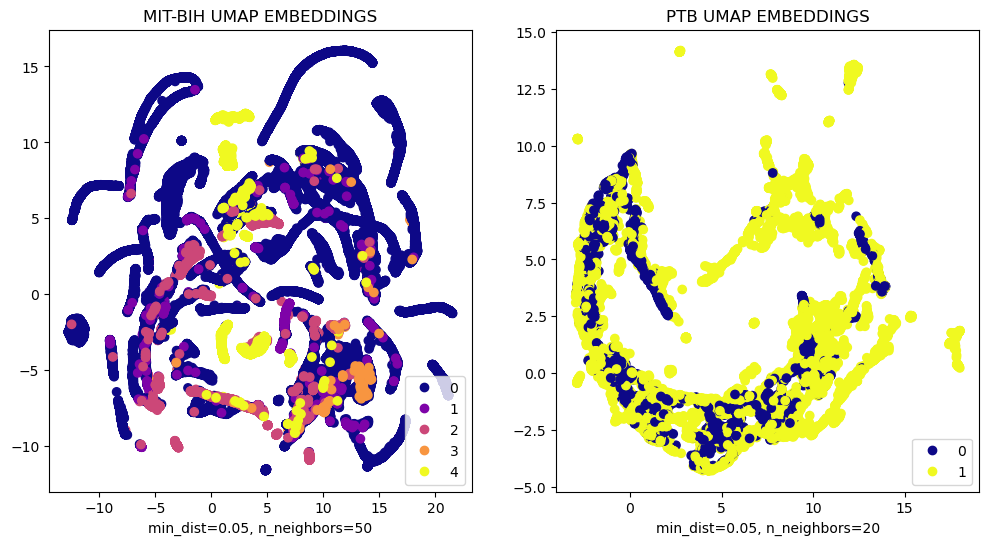

In [7]:
# 1x2 plot of UMAP embeddings
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# MITBIH
scatter = ax[0].scatter(umap_mitbih[:, 0], umap_mitbih[:, 1], c=mitbih_labels, cmap=plt.cm.plasma)
ax[0].set_title(f'MIT-BIH UMAP EMBEDDINGS')
ax[0].set_xlabel('min_dist=0.05, n_neighbors=50')
ax[0].legend(*scatter.legend_elements(),loc='lower right')

# PTBDB
scatter = ax[1].scatter(umap_ptbdb[:, 0], umap_ptbdb[:, 1], c=ptbdb_labels, cmap=plt.cm.plasma)
ax[1].set_title(f'PTB UMAP EMBEDDINGS')
ax[1].set_xlabel('min_dist=0.05, n_neighbors=20')
ax[1].legend(*scatter.legend_elements(),loc='lower right')

In [12]:
# Use KL Divergence quantify the difference between the distributions
kl_div1 = KLdivergence(umap_mitbih, umap_ptbdb)
kl_div2 = KLdivergence(umap_ptbdb, umap_mitbih)

print("Mean KL divergence MITBIH-PTB:", round((kl_div1 + kl_div2) / 2, 4))

Mean KL divergence MITBIH-PTB: 8.8628


In [11]:
class0_indices = np.where(ptbdb_labels == 0)[0]
class1_indices = np.where(ptbdb_labels == 1)[0]
umap_ptbdb_class0 = umap_ptbdb[class0_indices]
umap_ptbdb_class1 = umap_ptbdb[class1_indices]
kl_div_class0_class1_1 = KLdivergence(umap_ptbdb_class0, umap_ptbdb_class1)
kl_div_class0_class1_2 = KLdivergence(umap_ptbdb_class1, umap_ptbdb_class0)

print("Mean KL divergence PTBDB class 0 - class 1:", round((kl_div_class0_class1_1 + kl_div_class0_class1_2) / 2, 4))

Mean KL divergence PTBDB class 0 - class 1: 3.9302


In [13]:
# Mean KL divergence between classes of mitbih
umap_mitbih_class0 = umap_mitbih[np.where(mitbih_labels == 0)[0]]
umap_mitbih_class1 = umap_mitbih[np.where(mitbih_labels == 1)[0]]
umap_mitbih_class2 = umap_mitbih[np.where(mitbih_labels == 2)[0]]
umap_mitbih_class3 = umap_mitbih[np.where(mitbih_labels == 3)[0]]
umap_mitbih_class4 = umap_mitbih[np.where(mitbih_labels == 4)[0]]

kl_divergences = []

# Compute KL divergence for all combinations
kl_div_class0_class1_1 = KLdivergence(umap_mitbih_class0, umap_mitbih_class1)
kl_div_class0_class1_2 = KLdivergence(umap_mitbih_class1, umap_mitbih_class0)

kl_div_class0_class2_1 = KLdivergence(umap_mitbih_class0, umap_mitbih_class2)
kl_div_class0_class2_2 = KLdivergence(umap_mitbih_class2, umap_mitbih_class0)

kl_div_class0_class3_1 = KLdivergence(umap_mitbih_class0, umap_mitbih_class3)
kl_div_class0_class3_2 = KLdivergence(umap_mitbih_class3, umap_mitbih_class0)

kl_div_class0_class4_1 = KLdivergence(umap_mitbih_class0, umap_mitbih_class4)
kl_div_class0_class4_2 = KLdivergence(umap_mitbih_class4, umap_mitbih_class0)

kl_div_class1_class2_1 = KLdivergence(umap_mitbih_class1, umap_mitbih_class2)
kl_div_class1_class2_2 = KLdivergence(umap_mitbih_class2, umap_mitbih_class1)

kl_div_class1_class3_1 = KLdivergence(umap_mitbih_class1, umap_mitbih_class3)
kl_div_class1_class3_2 = KLdivergence(umap_mitbih_class3, umap_mitbih_class1)

kl_div_class1_class4_1 = KLdivergence(umap_mitbih_class1, umap_mitbih_class4)
kl_div_class1_class4_2 = KLdivergence(umap_mitbih_class4, umap_mitbih_class1)

kl_div_class2_class3_1 = KLdivergence(umap_mitbih_class2, umap_mitbih_class3)
kl_div_class2_class3_2 = KLdivergence(umap_mitbih_class3, umap_mitbih_class2)

kl_div_class2_class4_1 = KLdivergence(umap_mitbih_class2, umap_mitbih_class4)
kl_div_class2_class4_2 = KLdivergence(umap_mitbih_class4, umap_mitbih_class2)

kl_div_class3_class4_1 = KLdivergence(umap_mitbih_class3, umap_mitbih_class4)
kl_div_class3_class4_2 = KLdivergence(umap_mitbih_class4, umap_mitbih_class3)

print("Mean KL divergence MITBIH class 0 - class 1:", round((kl_div_class0_class1_1 + kl_div_class0_class1_2) / 2, 4))
print("Mean KL divergence MITBIH class 0 - class 2:", round((kl_div_class0_class2_1 + kl_div_class0_class2_2) / 2, 4))
print("Mean KL divergence MITBIH class 0 - class 3:", round((kl_div_class0_class3_1 + kl_div_class0_class3_2) / 2, 4))
print("Mean KL divergence MITBIH class 0 - class 4:", round((kl_div_class0_class4_1 + kl_div_class0_class4_2) / 2, 4))
print("Mean KL divergence MITBIH class 1 - class 2:", round((kl_div_class1_class2_1 + kl_div_class1_class2_2) / 2, 4))
print("Mean KL divergence MITBIH class 1 - class 3:", round((kl_div_class1_class3_1 + kl_div_class1_class3_2) / 2, 4))
print("Mean KL divergence MITBIH class 1 - class 4:", round((kl_div_class1_class4_1 + kl_div_class1_class4_2) / 2, 4))
print("Mean KL divergence MITBIH class 2 - class 3:", round((kl_div_class2_class3_1 + kl_div_class2_class3_2) / 2, 4))
print("Mean KL divergence MITBIH class 2 - class 4:", round((kl_div_class2_class4_1 + kl_div_class2_class4_2) / 2, 4))
print("Mean KL divergence MITBIH class 3 - class 4:", round((kl_div_class3_class4_1 + kl_div_class3_class4_2) / 2, 4))


Mean KL divergence MITBIH class 0 - class 1: 6.1929
Mean KL divergence MITBIH class 0 - class 2: 8.2237
Mean KL divergence MITBIH class 0 - class 3: 7.0922
Mean KL divergence MITBIH class 0 - class 4: 11.1
Mean KL divergence MITBIH class 1 - class 2: 8.9781
Mean KL divergence MITBIH class 1 - class 3: 8.9451
Mean KL divergence MITBIH class 1 - class 4: 12.2057
Mean KL divergence MITBIH class 2 - class 3: 6.2905
Mean KL divergence MITBIH class 2 - class 4: 9.6448
Mean KL divergence MITBIH class 3 - class 4: 11.1858
